# Variational Autoencoder (VAE)

## 1. Introduction

A **Variational Autoencoder (VAE)** is a generative model that combines deep learning with Bayesian inference. Unlike traditional autoencoders that learn deterministic encodings, VAEs learn a probabilistic latent representation, enabling them to generate new samples from the learned distribution.

## 2. Theoretical Foundation

### 2.1 Generative Model Perspective

VAEs model the joint distribution of observed data $\mathbf{x}$ and latent variables $\mathbf{z}$:

$$p(\mathbf{x}, \mathbf{z}) = p(\mathbf{x}|\mathbf{z})p(\mathbf{z})$$

where:
- $p(\mathbf{z})$ is the prior distribution over latent variables (typically $\mathcal{N}(0, I)$)
- $p(\mathbf{x}|\mathbf{z})$ is the likelihood (decoder network)

### 2.2 The Intractability Problem

The posterior distribution $p(\mathbf{z}|\mathbf{x})$ is intractable because computing the marginal likelihood requires integration:

$$p(\mathbf{x}) = \int p(\mathbf{x}|\mathbf{z})p(\mathbf{z})d\mathbf{z}$$

### 2.3 Variational Inference

We approximate the intractable posterior with a variational distribution $q_\phi(\mathbf{z}|\mathbf{x})$ (encoder network). The goal is to minimize the Kullback-Leibler divergence:

$$D_{KL}(q_\phi(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z}|\mathbf{x}))$$

### 2.4 Evidence Lower Bound (ELBO)

Minimizing the KL divergence is equivalent to maximizing the Evidence Lower Bound:

$$\mathcal{L}(\theta, \phi; \mathbf{x}) = \mathbb{E}_{q_\phi(\mathbf{z}|\mathbf{x})}[\log p_\theta(\mathbf{x}|\mathbf{z})] - D_{KL}(q_\phi(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z}))$$

This decomposes into:
- **Reconstruction term**: $\mathbb{E}_{q_\phi(\mathbf{z}|\mathbf{x})}[\log p_\theta(\mathbf{x}|\mathbf{z})]$ - measures how well the decoder reconstructs data
- **Regularization term**: $-D_{KL}(q_\phi(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z}))$ - ensures the latent distribution stays close to the prior

### 2.5 Reparameterization Trick

To enable backpropagation through the sampling operation, we use the reparameterization trick. For a Gaussian encoder:

$$\mathbf{z} = \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, I)$$

where $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ are outputs of the encoder network.

### 2.6 KL Divergence for Gaussians

For Gaussian distributions, the KL divergence has a closed form:

$$D_{KL}(\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2) \| \mathcal{N}(0, I)) = -\frac{1}{2}\sum_{j=1}^{J}(1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2)$$

where $J$ is the dimension of the latent space.

## 3. Implementation

We will implement a VAE from scratch using NumPy to demonstrate the core concepts. Our VAE will:
1. Learn to encode/decode 2D data points
2. Use a 2D latent space for visualization
3. Generate new samples from the learned distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

# Generate synthetic 2D data: mixture of Gaussians
def generate_data(n_samples=1000):
    """Generate 2D data from a mixture of Gaussians."""
    n_per_cluster = n_samples // 4
    
    # Four clusters
    centers = [(-2, -2), (-2, 2), (2, -2), (2, 2)]
    data = []
    
    for center in centers:
        cluster = np.random.randn(n_per_cluster, 2) * 0.5 + np.array(center)
        data.append(cluster)
    
    return np.vstack(data)

# Generate training data
X_train = generate_data(2000)
print(f"Training data shape: {X_train.shape}")

Training data shape: (2000, 2)


In [2]:
class VAE:
    """
    Variational Autoencoder with single hidden layer.
    
    Architecture:
    - Encoder: input_dim -> hidden_dim -> (mu, log_var) of latent_dim
    - Decoder: latent_dim -> hidden_dim -> output_dim
    """
    
    def __init__(self, input_dim=2, hidden_dim=16, latent_dim=2):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Initialize weights with Xavier initialization
        scale = 0.1
        
        # Encoder weights
        self.W_enc1 = np.random.randn(input_dim, hidden_dim) * scale
        self.b_enc1 = np.zeros(hidden_dim)
        self.W_mu = np.random.randn(hidden_dim, latent_dim) * scale
        self.b_mu = np.zeros(latent_dim)
        self.W_logvar = np.random.randn(hidden_dim, latent_dim) * scale
        self.b_logvar = np.zeros(latent_dim)
        
        # Decoder weights
        self.W_dec1 = np.random.randn(latent_dim, hidden_dim) * scale
        self.b_dec1 = np.zeros(hidden_dim)
        self.W_dec2 = np.random.randn(hidden_dim, input_dim) * scale
        self.b_dec2 = np.zeros(input_dim)
        
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def encode(self, x):
        """Encode input to latent distribution parameters."""
        self.h_enc = self.relu(x @ self.W_enc1 + self.b_enc1)
        mu = self.h_enc @ self.W_mu + self.b_mu
        log_var = self.h_enc @ self.W_logvar + self.b_logvar
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        """Sample z using reparameterization trick."""
        std = np.exp(0.5 * log_var)
        eps = np.random.randn(*mu.shape)
        return mu + eps * std, eps
    
    def decode(self, z):
        """Decode latent vector to reconstruction."""
        self.h_dec = self.relu(z @ self.W_dec1 + self.b_dec1)
        x_recon = self.h_dec @ self.W_dec2 + self.b_dec2
        return x_recon
    
    def forward(self, x):
        """Forward pass through the VAE."""
        mu, log_var = self.encode(x)
        z, eps = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var, z, eps
    
    def compute_loss(self, x, x_recon, mu, log_var):
        """Compute VAE loss: reconstruction + KL divergence."""
        # Reconstruction loss (MSE)
        recon_loss = np.mean(np.sum((x - x_recon)**2, axis=1))
        
        # KL divergence loss
        kl_loss = -0.5 * np.mean(np.sum(1 + log_var - mu**2 - np.exp(log_var), axis=1))
        
        return recon_loss + kl_loss, recon_loss, kl_loss
    
    def backward(self, x, x_recon, mu, log_var, z, eps, lr=0.001):
        """Backward pass with gradient descent."""
        batch_size = x.shape[0]
        std = np.exp(0.5 * log_var)
        
        # Gradient of reconstruction loss w.r.t. x_recon
        d_recon = 2 * (x_recon - x) / batch_size
        
        # Decoder gradients
        d_W_dec2 = self.h_dec.T @ d_recon
        d_b_dec2 = np.sum(d_recon, axis=0)
        
        d_h_dec = d_recon @ self.W_dec2.T
        d_h_dec = d_h_dec * self.relu_derivative(self.h_dec)
        
        d_W_dec1 = z.T @ d_h_dec
        d_b_dec1 = np.sum(d_h_dec, axis=0)
        
        # Gradient w.r.t. z
        d_z = d_h_dec @ self.W_dec1.T
        
        # Gradient w.r.t. mu and log_var (through reparameterization)
        d_mu = d_z + mu / batch_size  # KL gradient for mu
        d_log_var = d_z * eps * 0.5 * std + 0.5 * (np.exp(log_var) - 1) / batch_size  # KL gradient for log_var
        
        # Encoder gradients for mu path
        d_W_mu = self.h_enc.T @ d_mu
        d_b_mu = np.sum(d_mu, axis=0)
        
        # Encoder gradients for log_var path
        d_W_logvar = self.h_enc.T @ d_log_var
        d_b_logvar = np.sum(d_log_var, axis=0)
        
        # Gradient w.r.t. h_enc
        d_h_enc = d_mu @ self.W_mu.T + d_log_var @ self.W_logvar.T
        d_h_enc = d_h_enc * self.relu_derivative(self.h_enc)
        
        d_W_enc1 = x.T @ d_h_enc
        d_b_enc1 = np.sum(d_h_enc, axis=0)
        
        # Update weights
        self.W_enc1 -= lr * d_W_enc1
        self.b_enc1 -= lr * d_b_enc1
        self.W_mu -= lr * d_W_mu
        self.b_mu -= lr * d_b_mu
        self.W_logvar -= lr * d_W_logvar
        self.b_logvar -= lr * d_b_logvar
        self.W_dec1 -= lr * d_W_dec1
        self.b_dec1 -= lr * d_b_dec1
        self.W_dec2 -= lr * d_W_dec2
        self.b_dec2 -= lr * d_b_dec2
    
    def train(self, X, epochs=500, batch_size=64, lr=0.01):
        """Train the VAE."""
        n_samples = X.shape[0]
        losses = {'total': [], 'recon': [], 'kl': []}
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            
            epoch_loss = 0
            epoch_recon = 0
            epoch_kl = 0
            n_batches = 0
            
            for i in range(0, n_samples, batch_size):
                batch = X_shuffled[i:i+batch_size]
                
                # Forward pass
                x_recon, mu, log_var, z, eps = self.forward(batch)
                
                # Compute loss
                loss, recon_loss, kl_loss = self.compute_loss(batch, x_recon, mu, log_var)
                
                # Backward pass
                self.backward(batch, x_recon, mu, log_var, z, eps, lr)
                
                epoch_loss += loss
                epoch_recon += recon_loss
                epoch_kl += kl_loss
                n_batches += 1
            
            losses['total'].append(epoch_loss / n_batches)
            losses['recon'].append(epoch_recon / n_batches)
            losses['kl'].append(epoch_kl / n_batches)
            
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {losses['total'][-1]:.4f}, "
                      f"Recon: {losses['recon'][-1]:.4f}, KL: {losses['kl'][-1]:.4f}")
        
        return losses
    
    def sample(self, n_samples):
        """Generate samples from the prior."""
        z = np.random.randn(n_samples, self.latent_dim)
        return self.decode(z)

In [3]:
# Create and train VAE
vae = VAE(input_dim=2, hidden_dim=32, latent_dim=2)
losses = vae.train(X_train, epochs=500, batch_size=64, lr=0.01)

Epoch 100/500, Loss: 2.8163, Recon: 0.8582, KL: 1.9581


Epoch 200/500, Loss: 2.6663, Recon: 0.7847, KL: 1.8817


Epoch 300/500, Loss: 2.6269, Recon: 0.7552, KL: 1.8717


Epoch 400/500, Loss: 2.6559, Recon: 0.7571, KL: 1.8988


Epoch 500/500, Loss: 2.5796, Recon: 0.7755, KL: 1.8042


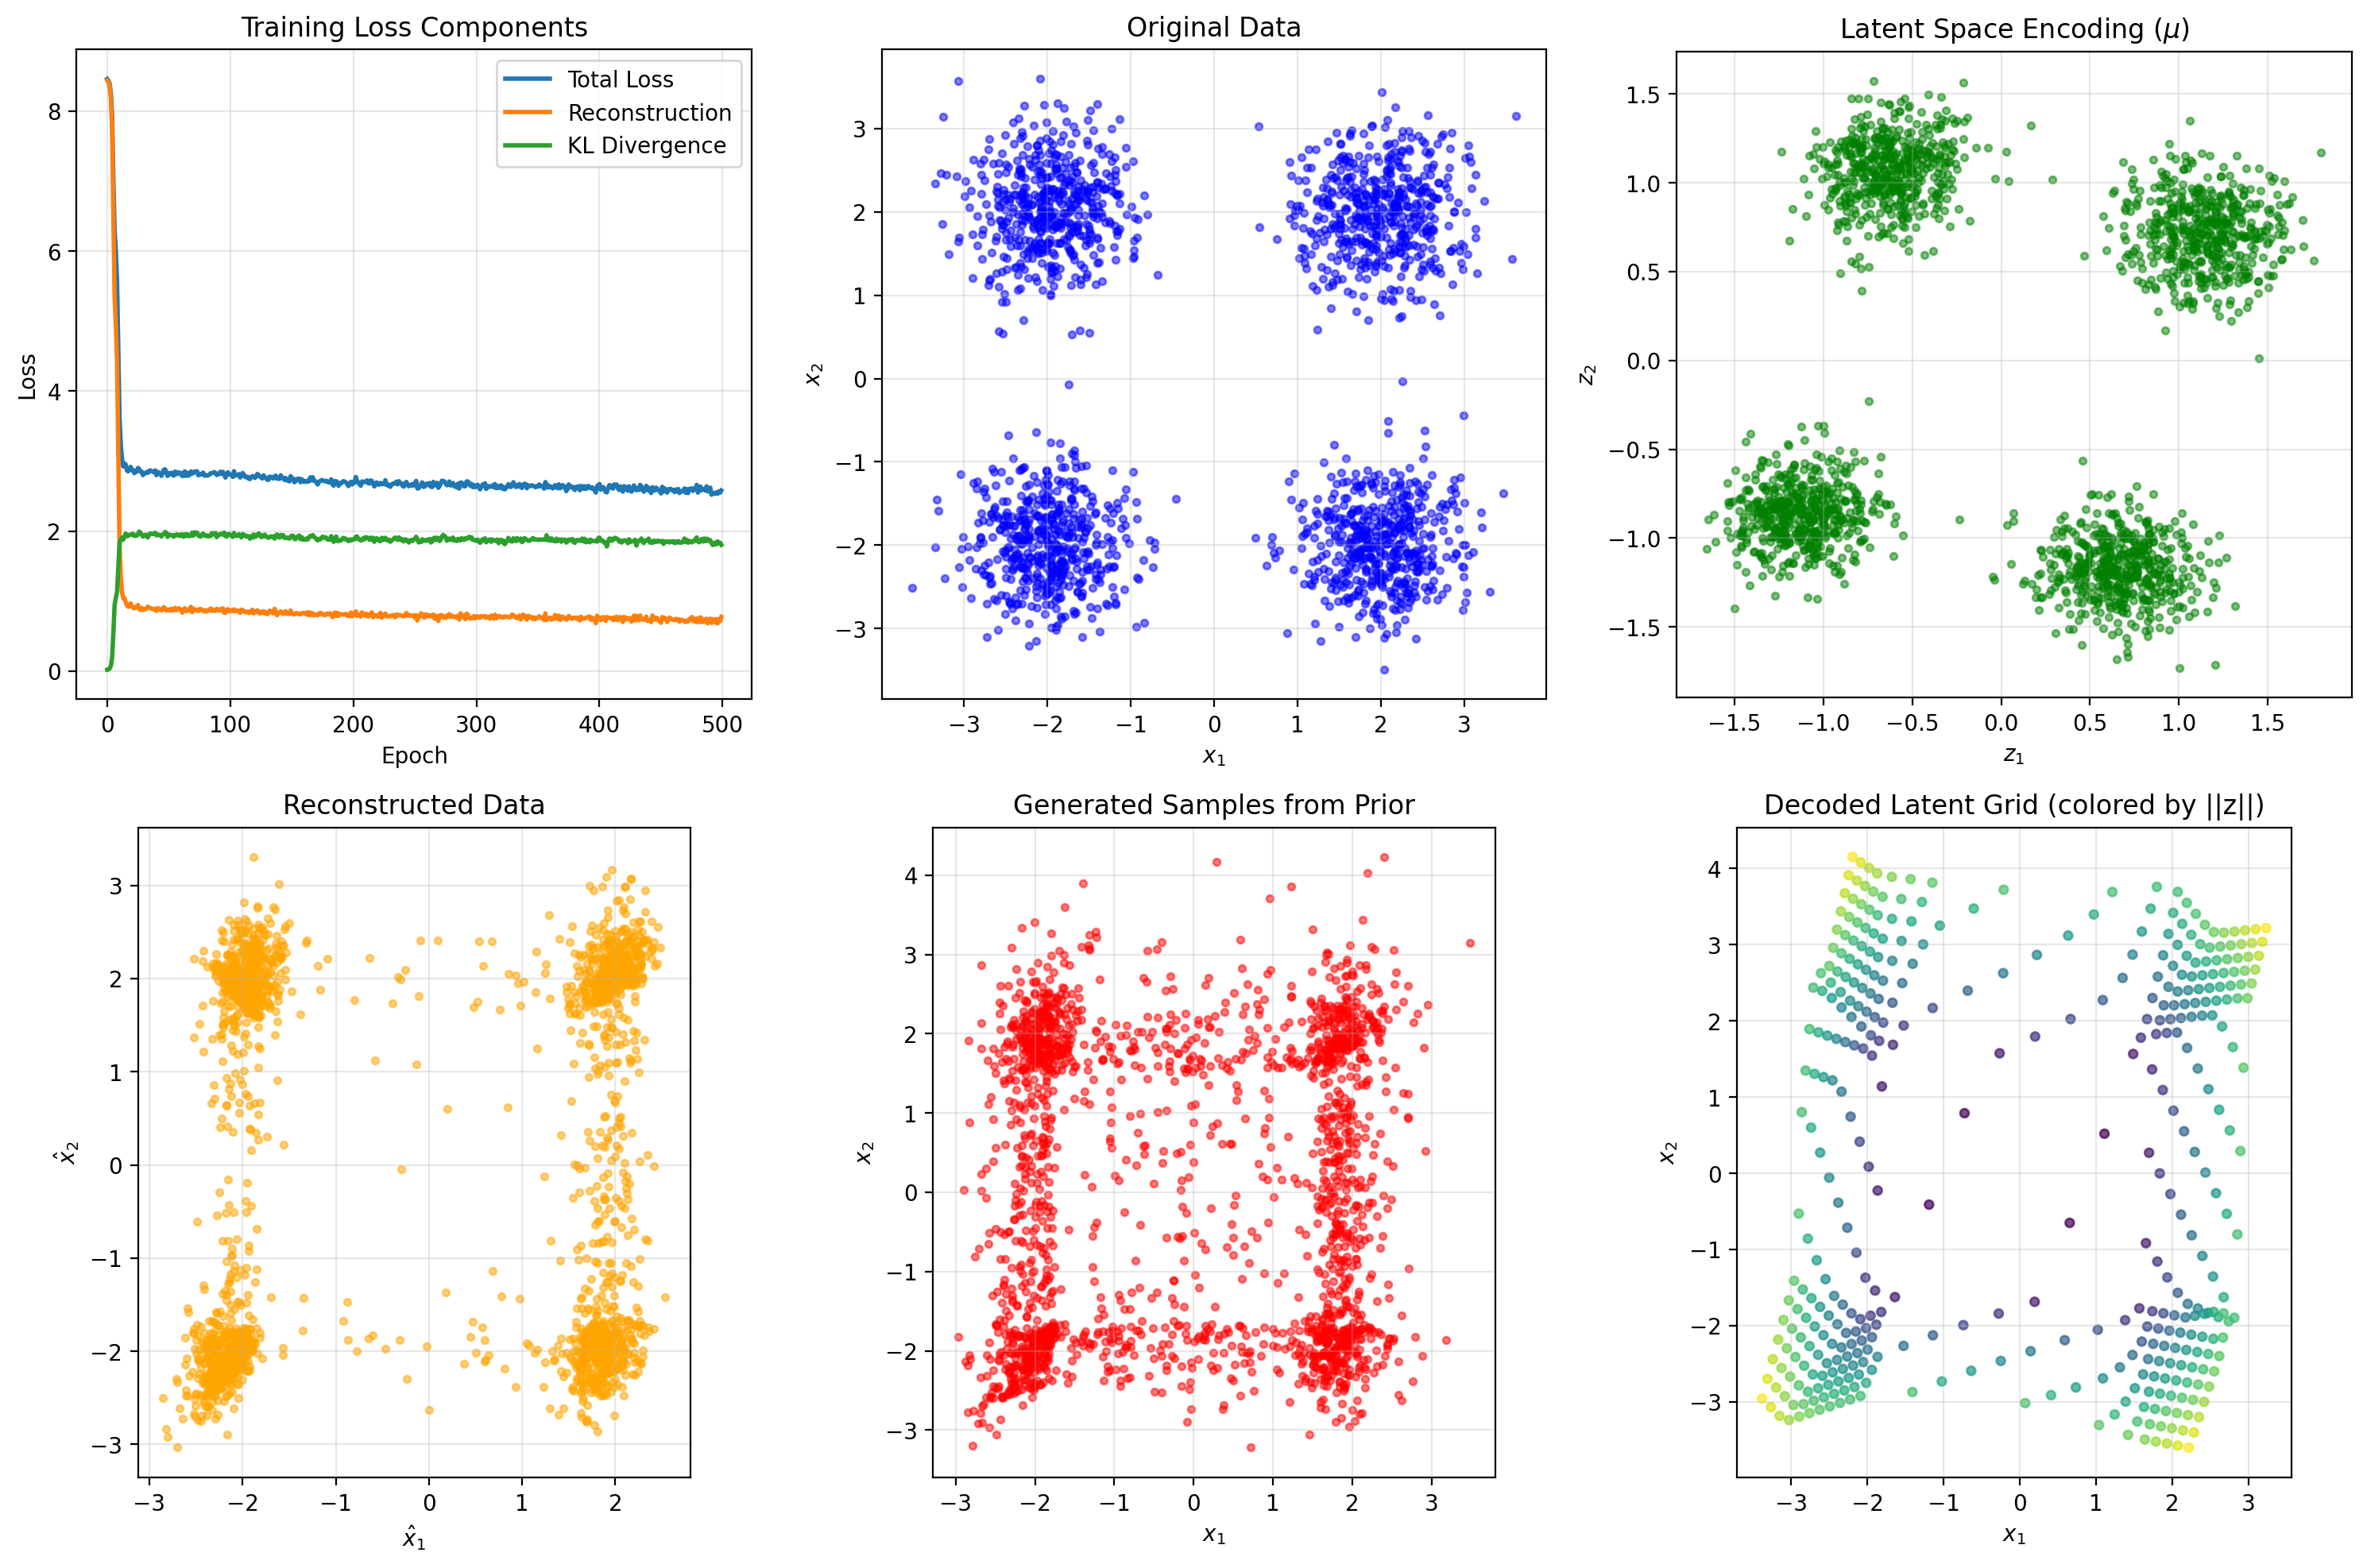


Figure saved to plot.png


In [4]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Training loss curves
ax1 = axes[0, 0]
ax1.plot(losses['total'], label='Total Loss', linewidth=2)
ax1.plot(losses['recon'], label='Reconstruction', linewidth=2)
ax1.plot(losses['kl'], label='KL Divergence', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Components')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Original data
ax2 = axes[0, 1]
ax2.scatter(X_train[:, 0], X_train[:, 1], alpha=0.5, s=10, c='blue')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_title('Original Data')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

# Plot 3: Latent space encoding
mu, log_var = vae.encode(X_train)
ax3 = axes[0, 2]
scatter = ax3.scatter(mu[:, 0], mu[:, 1], alpha=0.5, s=10, c='green')
ax3.set_xlabel('$z_1$')
ax3.set_ylabel('$z_2$')
ax3.set_title('Latent Space Encoding ($\\mu$)')
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')

# Plot 4: Reconstructions
x_recon, _, _, _, _ = vae.forward(X_train)
ax4 = axes[1, 0]
ax4.scatter(x_recon[:, 0], x_recon[:, 1], alpha=0.5, s=10, c='orange')
ax4.set_xlabel('$\\hat{x}_1$')
ax4.set_ylabel('$\\hat{x}_2$')
ax4.set_title('Reconstructed Data')
ax4.grid(True, alpha=0.3)
ax4.set_aspect('equal')

# Plot 5: Generated samples from prior
generated = vae.sample(2000)
ax5 = axes[1, 1]
ax5.scatter(generated[:, 0], generated[:, 1], alpha=0.5, s=10, c='red')
ax5.set_xlabel('$x_1$')
ax5.set_ylabel('$x_2$')
ax5.set_title('Generated Samples from Prior')
ax5.grid(True, alpha=0.3)
ax5.set_aspect('equal')

# Plot 6: Latent space traversal (2D manifold)
ax6 = axes[1, 2]
n_grid = 20
z1_range = np.linspace(-3, 3, n_grid)
z2_range = np.linspace(-3, 3, n_grid)
Z1, Z2 = np.meshgrid(z1_range, z2_range)
z_grid = np.column_stack([Z1.ravel(), Z2.ravel()])

# Decode grid points
decoded_grid = vae.decode(z_grid)
ax6.scatter(decoded_grid[:, 0], decoded_grid[:, 1], 
            c=np.linalg.norm(z_grid, axis=1), cmap='viridis', 
            alpha=0.7, s=15)
ax6.set_xlabel('$x_1$')
ax6.set_ylabel('$x_2$')
ax6.set_title('Decoded Latent Grid (colored by ||z||)')
ax6.grid(True, alpha=0.3)
ax6.set_aspect('equal')

plt.tight_layout()
plt.savefig('variational_autoencoder_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to plot.png")

## 4. Results Analysis

### 4.1 Loss Decomposition

The training dynamics show the interplay between reconstruction and regularization:
- **Reconstruction loss** decreases as the model learns to encode/decode data
- **KL divergence** ensures the latent distribution approximates $\mathcal{N}(0, I)$

### 4.2 Latent Space Structure

The latent space visualization shows that:
- Data is encoded into a continuous, smooth manifold
- The KL regularization encourages a compact representation centered at origin
- Different clusters in data space map to different regions in latent space

### 4.3 Generative Capability

Sampling from the prior $\mathcal{N}(0, I)$ and decoding produces new data points that:
- Follow the same distribution as training data
- Demonstrate smooth interpolation between modes

## 5. Key Takeaways

1. **VAEs combine neural networks with variational inference** to learn probabilistic latent representations

2. **The ELBO objective balances two goals**: accurate reconstruction and latent space regularization

3. **The reparameterization trick** enables end-to-end training via backpropagation

4. **VAEs are true generative models** that can sample new data by decoding from the prior

5. **The latent space is continuous and structured**, enabling meaningful interpolation and manipulation